In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
import datetime

In [9]:
datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

'2021-04-29_13-01-56'

In [3]:
from lapd_ebm import sample_langevin, sample_langevin_cuda, ReplayBuffer
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
%matplotlib notebook
%load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

In [11]:
torch.cuda.is_available()

True

In [41]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
#         self.conv1 = torch.nn.Conv1d(1, 8, 8, stride=2, padding=0)
#         self.conv2 = torch.nn.Conv1d(8, 4, 8, stride=2, padding=0)
#         self.conv3 = torch.nn.Conv1d(4, 1, 8, stride=2, padding=0)        
#         self.dense1 = torch.nn.Linear(52, 32)
#         self.dense2 = torch.nn.Linear(32, 32)
#         self.dense3 = torch.nn.Linear(32, 1)
        self.dense1 = torch.nn.Linear(10, 1024)
        self.dense2 = torch.nn.Linear(1024, 1024)
        self.dense3 = torch.nn.Linear(1024, 1024)
#         self.dense4 = torch.nn.Linear(128, 128)
#         self.dense5 = torch.nn.Linear(128, 128)
#         self.dense6 = torch.nn.Linear(256, 256)
#         self.dense7 = torch.nn.Linear(256, 256)
#         self.dense8 = torch.nn.Linear(256, 256)
        self.denseEnd = torch.nn.Linear(1024, 1)
        
        self.dense1 = torch.nn.utils.spectral_norm(self.dense1)
        self.dense2 = torch.nn.utils.spectral_norm(self.dense2)
        self.dense3 = torch.nn.utils.spectral_norm(self.dense3)
#         self.dense4 = torch.nn.utils.spectral_norm(self.dense4)
#         self.dense5 = torch.nn.utils.spectral_norm(self.dense5)
        self.denseEnd = torch.nn.utils.spectral_norm(self.denseEnd)
        
    def forward(self, x):
#         info = x[:, 0:2]
#         x = x[:, 2:]
        
        SiLU = torch.nn.functional.silu
#         x = x.unsqueeze(dim=1)        
#         x = SiLU(self.conv1(x))
#         x = SiLU(self.conv2(x))
#         x = SiLU(self.conv3(x))
#         x = x.squeeze()
#         x = torch.cat((info, x), 1)
#         x = SiLU(self.dense1(x))
#         x = SiLU(self.dense2(x))
#         x = self.dense3(x)
        
        x = SiLU(self.dense1(x))
        x = SiLU(self.dense2(x))
        x = SiLU(self.dense3(x))
#         x = SiLU(self.dense4(x))
#         x = SiLU(self.dense5(x))
#         x = SiLU(self.dense6(x))
#         x = SiLU(self.dense7(x))
#         x = SiLU(self.dense8(x))
        x = self.denseEnd(x)
    
        return x               

In [243]:
for name, weight in model.named_parameters():
    print(name, weight)

dense1.bias Parameter containing:
tensor([ 1.9419e-01,  5.5743e-02, -2.6888e-01,  1.4568e-02, -7.8859e-02,
        -2.4795e-01, -5.5057e-02, -6.8042e-02, -7.0261e-02, -1.3323e-01,
         1.0171e-01, -3.2855e-02, -8.5012e-02,  6.8169e-02,  2.4360e-01,
         2.4911e-01,  1.1153e-01, -1.6928e-01, -1.7571e-01, -2.9010e-01,
        -2.3242e-01,  1.4085e-01,  1.9509e-02,  3.1252e-01,  9.8720e-02,
        -8.0197e-02, -7.5271e-02, -1.6102e-02,  1.0344e-01, -1.5966e-01,
         3.0060e-01, -2.3393e-01, -2.4385e-01,  8.2848e-02, -7.9542e-02,
         2.4331e-01, -1.4756e-01, -2.4640e-02,  5.5463e-02, -7.4839e-02,
         2.0679e-02, -1.5121e-01, -1.5409e-01, -2.5298e-01,  3.0195e-01,
        -1.5666e-01, -1.0837e-01, -1.7485e-04, -1.9195e-01,  4.0777e-03,
        -7.7745e-02, -2.7982e-01, -3.5757e-01,  3.0145e-01, -5.7541e-02,
        -2.0535e-01,  3.1774e-01, -2.8469e-01, -1.0775e-01,  1.6993e-01,
         1.7627e-01, -1.2309e-01,  1.0318e-01, -7.7010e-02], device='cuda:0',
       requi

If CUDA errors out for no reason, do
```
sudo rmmod nvidia_uvm
sudo modprobe nvidia_uvm
```

In [361]:
ckpt = torch.load("models/model-best-2021-4-27-4000.pt")

model = NeuralNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0, betas=(0.0, 0.999))

model.load_state_dict(ckpt['model_state_dict'], strict=False)
# optimizer.load_state_dict(ckpt['optimizer_state_dict'])

epoch =  ckpt['epoch']
reg_amount =  ckpt['reg_amount']
replay_frac =  ckpt['replay_frac']
replay_buffer =  ckpt['replay_buffer']
sample_steps =  ckpt['sample_steps']
step_size =  ckpt['step_size']
noise_scale =  ckpt['noise_scale']
losses =  ckpt['losses']
energies_pos =  ckpt['energies_pos']
energies_neg =  ckpt['energies_neg']

In [59]:
hyperparams = {
    "num_epochs": 50,
    "reg_amount": 1e0,
    "replay_frac": 0.95,
    "replay_size": 8192,
    "sample_steps": 10,
    "step_size": 1e0,
    "noise_scale": 1e-1,
    "batch_size_max": 128,
    "lr": 1e-3
}

num_epochs = hyperparams["num_epochs"]
reg_amount = hyperparams["reg_amount"]
replay_frac = hyperparams["replay_frac"]
replay_size = hyperparams["replay_size"]
sample_steps = hyperparams["sample_steps"]
step_size = hyperparams["step_size"]
noise_scale = hyperparams["noise_scale"]
batch_size_max = hyperparams["batch_size_max"]
lr = hyperparams["lr"]

writer = SummaryWriter(log_dir='log/exp32_test')
model = NeuralNet().cuda()
# model = NeuralNet()
data = torch.tensor(np.load("data/isat_downsampled_8.npz")['arr_0'].reshape(-1, 10)).float()
writer.add_graph(model, data[0:10].cuda())

dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data),
                                         batch_size=batch_size_max, shuffle=True, num_workers=24, pin_memory=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0, betas=(0.0, 0.999))
replay_buffer = ReplayBuffer(replay_size, np.random.randn(*data.shape))

num_data = data.shape[0]
num_batches = int(np.ceil(num_data / 128))

pbar = tqdm(total=num_epochs)
for epoch in range(num_epochs):
    loss_avg = 0
    reg_avg = 0
    energy_pos_list = torch.zeros((num_data, 1)).cuda()
    energy_neg_list = torch.zeros((num_data, 1)).cuda()

    for pos_x, i in zip(dataloader, range(num_batches)):
        pos_x = torch.Tensor(pos_x[0]).cuda()
#         pos_x = torch.Tensor(pos_x)
        pos_x.requires_grad = True
        batch_size = pos_x.shape[0]

        neg_x = replay_buffer.sample(int(batch_size * replay_frac))
        neg_x_rand = np.random.randn(batch_size - neg_x.shape[0], *list(pos_x.shape[1:]))*1
        neg_x = np.concatenate([neg_x, neg_x_rand], axis=0)
        neg_x = torch.Tensor(neg_x).cuda()
#         neg_x = torch.Tensor(neg_x)
        neg_x.requires_grad = True

        neg_x = sample_langevin(neg_x, model, sample_steps=sample_steps, step_size=step_size, noise_scale=noise_scale)
        replay_buffer.add(neg_x)

        optimizer.zero_grad()

        pos_energy = model(pos_x)
        neg_energy = model(neg_x.cuda())
#         neg_energy = model(neg_x)
        energy_regularization = (reg_amount * (pos_energy.square() +
                                              neg_energy.square())).mean()
        loss = (pos_energy - neg_energy).mean() + energy_regularization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        
        loss_avg += loss * batch_size / num_data
        reg_avg += energy_regularization * batch_size / num_data
        energy_pos_list[i * batch_size_max:i * batch_size_max + batch_size] = pos_energy
        energy_neg_list[i * batch_size_max:i * batch_size_max + batch_size] = neg_energy

    # scalars
    avg_energy_pos = energy_pos_list.mean()
    avg_energy_neg = energy_neg_list.mean()
    
    # histograms
    energy_pos_list -= avg_energy_pos
    energy_neg_list -= avg_energy_pos
    
    # write scalars and histograms
    writer.add_scalar("energy/loss", loss_avg, epoch)
    writer.add_scalar('energy/reg', reg_avg, epoch)
    writer.add_scalar("energy/positive", avg_energy_pos, epoch)
    writer.add_scalar("energy/negative", avg_energy_neg, epoch)
    writer.add_scalar("energy/negative_relative", avg_energy_neg - avg_energy_pos, epoch)
    
    writer.add_histogram("energy/pos_relative", energy_pos_list, epoch)
    writer.add_histogram("energy/neg_relative", energy_neg_list, epoch)

    for name, weight in model.named_parameters():
        writer.add_histogram("w/" + name, weight, epoch)
        writer.add_histogram(f'g/{name}.grad', weight.grad, epoch)
    writer.flush()
    
    pbar.set_description("Epoch: {}\t Loss: {:.3e}\t Pos: {:.3e} \t Neg: {:.3e}\t Neg_relative: {:.3e}".format(epoch, loss_avg,
                                                                                       avg_energy_pos, avg_energy_neg,
                                                                                          avg_energy_neg - avg_energy_pos))
    pbar.update(1)

pbar.close()
#     print("Epoch: {}\t Loss: {}".format(epoch, np.mean(total_loss)))
#     evaluated_list.append(model(grid_num).detach().numpy().reshape(200, 200))

/home/phil/anaconda3/envs/ebm/lib/python3.7/site-packages/torch/jit/_trace.py:966: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 1 element(s) (out of 10) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.40625 (30179.478515625 vs. 30179.072265625), which occurred at index (0, 0).
  _module_class,


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [58]:
torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           }, "log/exp31_test/adsfasdfasdf-{}.pt".format(epoch))

<IPython.core.display.Javascript object>


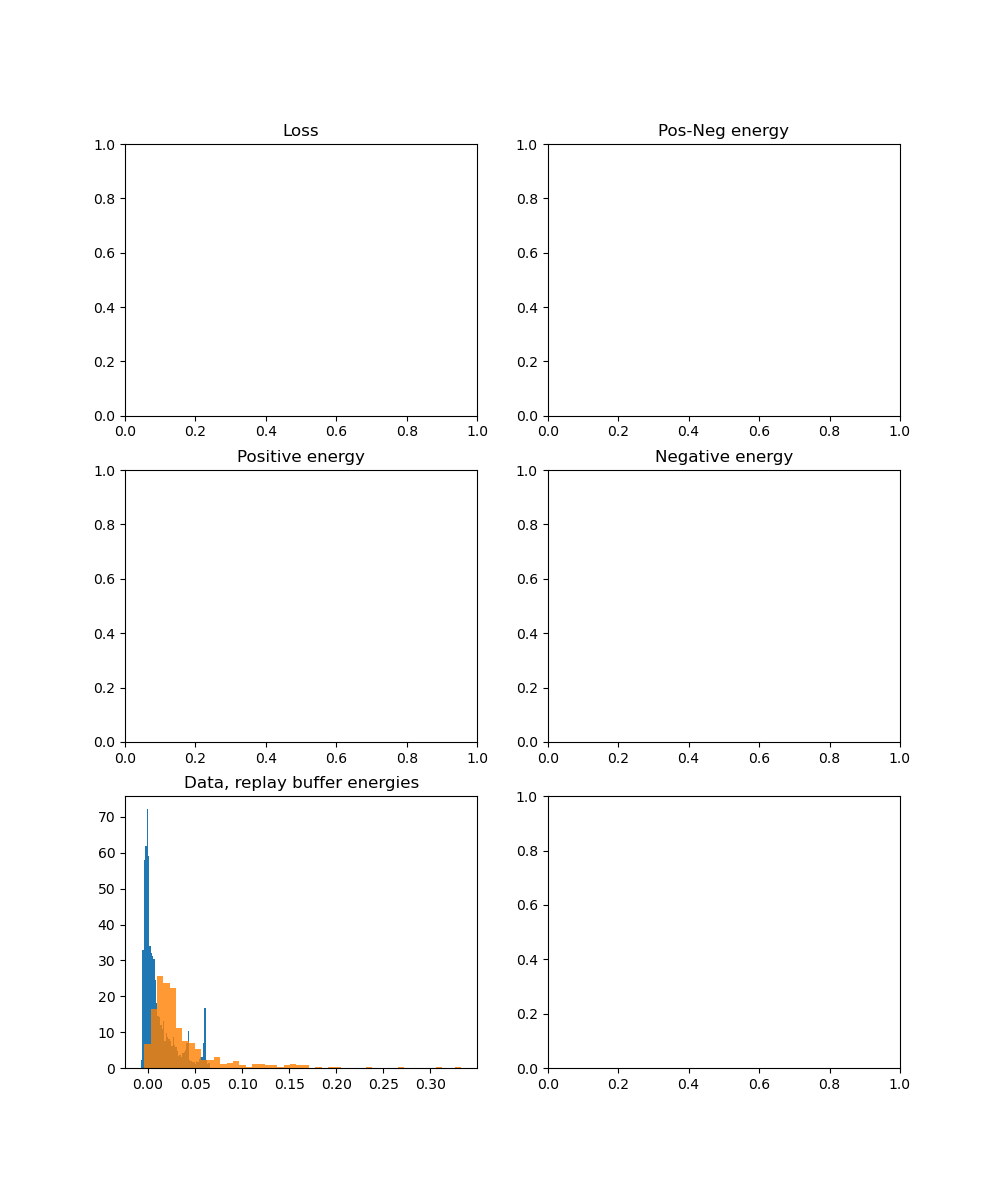

Text(0.5, 1.0, 'Data, replay buffer energies')

In [44]:
fig, axes = plt.subplots(3, 2, figsize=(10,12))
# axes[0, 0].plot((np.array(losses)).reshape(-1)+0.5)
# axes[0, 0].set_yscale('log')
# axes[0, 1].plot((np.array(energies_pos)).reshape(-1)-(np.array(energies_neg)).reshape(-1))
# axes[1, 0].plot((np.array(energies_pos)).reshape(-1))
# axes[1, 1].plot((np.array(energies_neg)).reshape(-1))
axes[2, 0].hist(model(data.cuda()).cpu().detach().numpy(), bins=50, density=True);
axes[2, 0].hist(model(torch.Tensor(replay_buffer.sample_list[:400]).cuda()).cpu().detach().numpy(), bins=50, density=True,
               color=(1, 0.5, 0.0, 0.8));

axes[0, 0].set_title('Loss')
axes[0, 1].set_title('Pos-Neg energy')
axes[1, 0].set_title('Positive energy')
axes[1, 1].set_title('Negative energy')
axes[2, 0].set_title('Data, replay buffer energies')
# axes[2, 1].set_title('Data energies')

In [49]:
n_samp = 1000
rand_num = torch.cat((torch.randn((n_samp, 1))*1,
                      torch.randn((n_samp, 1))*1,
                      torch.randn((n_samp, 8), requires_grad=True)*1), 1)
data.requires_grad=True
# torch.tensor(replay_buffer.sample_list[0:n_samp], requires_grad=True).float()
samples = sample_langevin(rand_num.cuda()[0:n_samp],
                          model, step_size=1e0, sample_steps=80, noise_scale=0.001, return_list=True)
for i in range(len(samples)):
    samples[i].cpu()

<IPython.core.display.Javascript object>


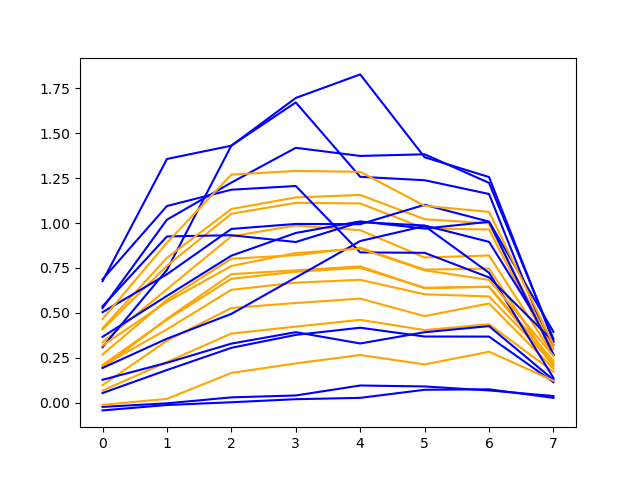

<IPython.core.display.Javascript object>


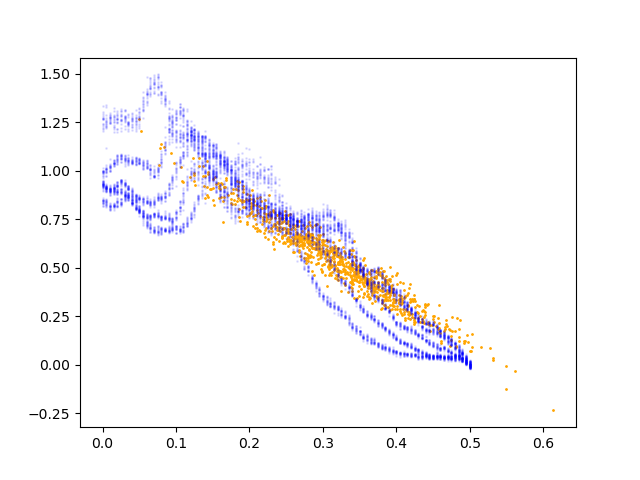

In [50]:
plt.figure()
for i in range(12):
    plt.plot(data.detach()[i*15*43][2:], color='blue')
    plt.plot(samples[-1][i][2:], color='orange')
# plt.plot(replay_buffer.sample_list[3])

plt.figure()
# plt.scatter(rand_num.detach().numpy()[:,0], np.mean(rand_num.detach().numpy()[:, 2:], axis=1), s=1)
plt.scatter(samples[-1].cpu().detach().numpy()[:, 0], np.mean(samples[-1].cpu().detach().numpy()[:, 2:], axis=1), s=1, color='orange')
# plt.scatter(replay_buffer.sample_list[:400, 0], np.mean(replay_buffer.sample_list[:400, 2:], axis=1), s=1, color='green')

plt.scatter(data.detach().numpy()[:, 0],
            np.mean(data.detach().numpy()[:, 2:], axis=1), s=1, color=(0, 0, 1, 0.1))
# plt.plot(np.linspace(0, 0.5, 101), data_plt[0, :], color=(0, 0, 1, 0.3))
# plt.plot(np.linspace(0, 0.5, 101), data_plt[1, :], color=(0, 0, 1, 0.3))
# plt.plot(np.linspace(0, 0.5, 101), data_plt[2, :], color=(0, 0, 1, 0.3))
# plt.plot(np.linspace(0, 0.5, 101), data_plt[3, :], color=(0, 0, 1, 0.3))
# plt.plot(np.linspace(0, 0.5, 101), data_plt[4, :], color=(0, 0, 1, 0.3))

# plt.figure()
# plt.imshow(model())

<IPython.core.display.Javascript object>


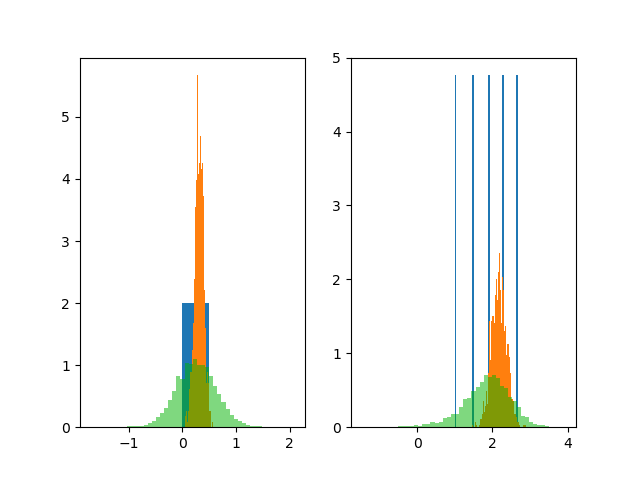

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(data.detach().numpy()[:, 0], bins=101, density=True);
ax1.hist(samples[-1].detach().numpy()[:, 0], bins=50, density=True);
ax1.hist(replay_buffer.sample_list[:, 0], bins=50, color=(0, 0.7, 0, 0.5), density=True);
ax2.hist(data.detach().numpy()[:, 1], bins=40, density=True);
ax2.hist(samples[-1].detach().numpy()[:, 1], bins=50, density=True);
ax2.hist(replay_buffer.sample_list[:, 1], bins=50, color=(0, 0.7, 0, 0.5), density=True);

In [13]:
data[0::15*101,1]

tensor([1.0000, 1.4700, 1.9000, 2.3000, 2.6800], grad_fn=<SelectBackward>)

<IPython.core.display.Javascript object>


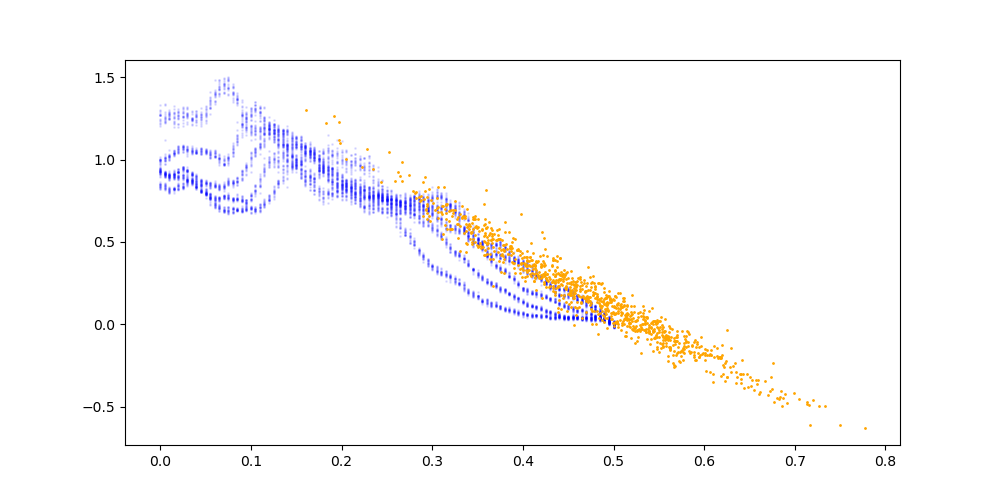

In [474]:
n_samp = 1000
cndstp = 1e0
rand_num = torch.cat((torch.randn((n_samp, 1))*1,
                      torch.randn((n_samp, 1))*0+1.9,
                      torch.randn((n_samp, 8), requires_grad=True)*1), 1)
data.requires_grad=True
# buf = torch.tensor(replay_buffer.sample_list[0:n_samp], requires_grad=True).float()
# buf[:, 1]=2
samples = sample_langevin(rand_num.cuda()[0:n_samp],
                          model, step_size=torch.Tensor([cndstp, 0, cndstp, cndstp, cndstp,
                                                         cndstp, cndstp, cndstp, cndstp, cndstp]).cuda(),
                          sample_steps=25, noise_scale=0.0, return_list=True)
for i in range(len(samples)):
    samples[i].cpu()

plt.figure(figsize=(10,5))
plt.scatter(data.detach().numpy()[:, 0],
            np.mean(data.detach().numpy()[:, 2:], axis=1), s=1, color=(0, 0, 1, 0.1))
plt.scatter(samples[-1].cpu().detach().numpy()[:, 0], np.mean(samples[-1].cpu().detach().numpy()[:, 5:6], axis=1), s=1, color='orange')
# plt.scatter(replay_buffer.sample_list[:400, 0], np.mean(replay_buffer.sample_list[:400, 2:], axis=1), s=1, color='green')


<IPython.core.display.Javascript object>


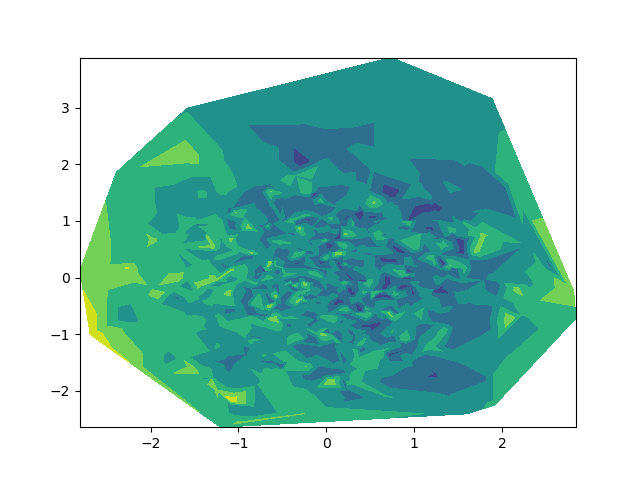

In [476]:
plt.figure()
rand_model = model.forward(rand_num.cuda()*4-2)
plt.tricontourf(rand_num[:, 0].detach().numpy(), rand_num[:, 1].detach().numpy(), rand_model.cpu().detach().numpy()[:,0])

4/22/2021
To get energy for position and magnetic field (plot above), need to marginalize over the profile! Comparing to the toy galaxy dataset, I should try increasing model capacity.

4/26/2021
* Seem to get good results when the loss is relatively flat / close to zero
* Need to profile this to figure out how to make it faster
* Diagnostics needed: energy of positive and negative samples, adjust sampler accordingly


* Turns out all you had to do to fix that weird training phase transition was lower the learning rate

Conditional sampling kind of works. Need the model to learn the distribution better somehow -- may just need to train it for a very long time. I should also build a rudimentary partition function estimator for calculating probabilities







































